In [2]:
import numpy as np
import alienlab
import pandas as pd
import matplotlib.pyplot as plt

from mvgavg import mvgavg
from tkinter.filedialog import askopenfilename
import os

from   scipy import optimize

%matplotlib inline

# Bode Diagram

**Experiment description:**   
No intensity filter on LEDs  
Filter x1e-2 on MPPC fluo  

480 constant 4V  
405 modulated offset 2V, amplitude 2V  

frequency range : 
    N = 30
    frequencies = 10**np.linspace(-2, 3, N)

### Log

see archive file

In [90]:
from statsmodels.regression import linear_model
from statsmodels.api import add_constant
from scipy.interpolate import InterpolatedUnivariateSpline
import numpy as np





def get_func(X, Y):
        Y = np.array([y for x, y in sorted(zip(X, Y))]) #preliminary sorting of the arrays along wavelength 
                                                            #(in case the graph in not properly ordered)
        X = np.sort(X)
        func = InterpolatedUnivariateSpline(X, Y) # interpolate given values with step 1 nm
        return func

def regression_affine(X, Y, details = True):
        Xreg = add_constant(X) #Add a constant to fit tan affine model

        model = linear_model.OLS(Y, Xreg) #Linear regression
        results = model.fit()
        [b, a] = results.params #parameters of the affine curve
        Yreg = a*X + b #regression curve

        return Yreg, a, b, results.summary()

def exp_decay(parameters,xdata):
    '''
    Calculate an exponetial decay of the form:
    S= a * exp(-xdata/b)
    '''
    A = parameters[0]
    tau = parameters[1]
    y0 = parameters[2]
    return A * np.exp(-xdata/tau) + y0

def band_pass(parameters, xdata):
    
    H = parameters[0]
    tau = parameters[1]
    a0 = parameters[2]
    
    return H * (xdata * tau) /(1 + (xdata  * tau)**2) + a0

def low_pass(parameters, xdata):
    
    H = parameters[0]
    tau = parameters[1]
    a0 = parameters[2]
    
    return H*(xdata * tau)**2 /(1 + (xdata * tau)**2) + a0

def high_pass(parameters, xdata):
    
    H = parameters[0]
    tau = parameters[1]
    a0 = parameters[2]
    
    return H /(1 + (xdata * tau)**2) + a0



def amplitude(parameters, xdata):
    
    H = parameters[0]
    tau = parameters[1]
    a0 = parameters[2]
    
    return (H /(1 + (xdata * tau)**2))**0.5 + a0

def residuals(parameters,x_data,y_observed,func):
    '''
    Compute residuals of y_predicted - y_observed
    where:
    y_predicted = func(parameters,x_data)
    '''
    return func(parameters,x_data) - y_observed


def averaging(measured_signal, 
                time_array, window, 
                do_binning = True):

    average_output = mvgavg(measured_signal, window, axis = 1, binning = do_binning)
    downscaled_time = time_array[window//2 :: window] 
    #todo: if binning == False, time array
    return average_output, downscaled_time    

def lock_in(self, measured_signal, 
            time_array, 
            frequency, phase_shift):
    cos_ref = np.cos(2*np.pi * frequency * time_array - phase_shift)
    cos_ref = np.stack([cos_ref] * measured_signal.shape[0])
    sin_ref = np.sin(2*np.pi * frequency * time_array - phase_shift)
    sin_ref = np.stack([sin_ref] * measured_signal.shape[0])
    cos_lock = 2 * np.multiply(measured_signal, cos_ref)
    sin_lock =  2 * np.multiply(measured_signal, sin_ref)
    radius_lock = np.sqrt(sin_lock.mean(axis = 1)**2 + cos_lock.mean(axis = 1)**2)
    phase_lock = np.arctan(sin_lock.mean(axis = 1)/cos_lock.mean(axis = 1))
    return sin_lock, cos_lock, radius_lock, phase_lock

In [62]:
file = "bode_full_response.csv"
curve = pd.read_csv(file, names = ['intensity', 'photodiode', 'fluo', 'tick', 'trigger'], sep = ',', decimal = '.') 

intensity = curve.intensity.values
photodiode = curve.photodiode.values
fluo = curve.fluo.values
tick = curve.tick.values


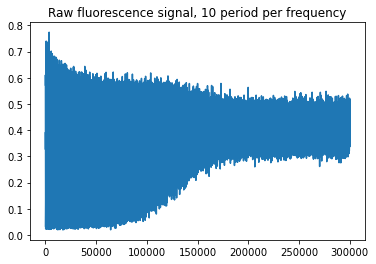

In [77]:
plt.plot(fluo)
plt.title('Raw fluorescence signal, 10 period per frequency')
plt.show()

In [78]:
time = np.linspace(0, len(fluo)-1, len(fluo))
f = 1 / (10000)
sinus = np.sin(time * f*2*np.pi)
cosinus = np.cos(time * f * 2 * np.pi)

In [79]:

window = 100
both = np.stack([fluo, tick], axis = 1)
smooth, time_bis = averaging(both.T, time, window)

Text(0.5, 1.0, 'smoothed fluorescence signal, 10 period per frequency')

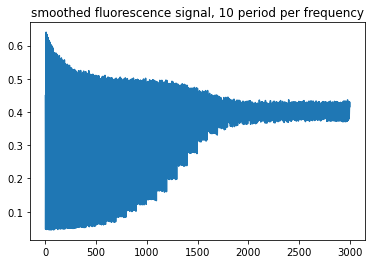

In [80]:
plt.plot(smooth[0])
plt.title('smoothed fluorescence signal, 10 period per frequency')
#plt.plot(smooth[1])

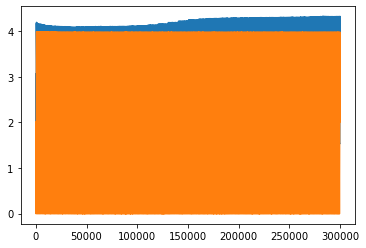

In [67]:
plt.figure()
plt.plot(photodiode)
plt.plot(tick)

In [81]:
files = os.listdir()
ind = [i for i, elem in enumerate(files) if 'fluo.csv' in elem]
path =files[ind[0]]


In [82]:
curve = pd.read_csv(path, sep = ',', decimal = '.') 

K = curve.keys()
d = 0
f = -5
frequencies = curve[K[1]].values[d:f]
radius = curve[K[2]].values[d:f]
sin_lo = curve[K[4]].values[d:f]
cos_lo = curve[K[6]].values[d:f]
phase = curve[K[8]].values[d:f]

l = 3
radius[0:l] = radius[l + 1]
sin_lo[0:l] = sin_lo[l + 1]
cos_lo[0:l] = cos_lo[l + 1]


cut-off cos:  0.11055036240959976
cut-off cos:  0.11055036240959976
cut-off radius: 0.1647270220046923


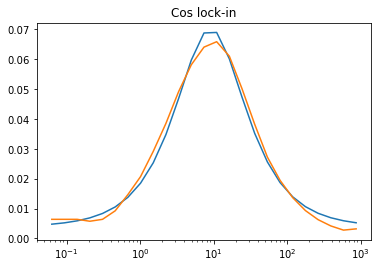

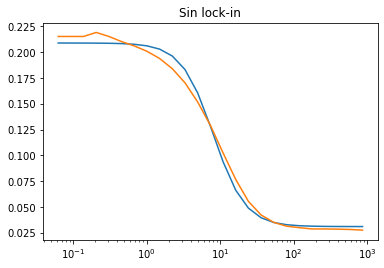

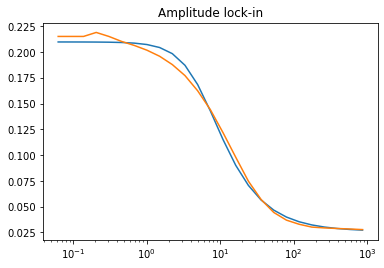

In [87]:

x0 = [0.1, 0.1, 0]

pulse = 2 * np.pi * frequencies
parameters_estimated = optimize.least_squares(residuals,  x0, bounds = (-1e5,1e5),
                                    args = (pulse, sin_lo, band_pass)).x
tau_sin = parameters_estimated[1]
print("cut-off cos: ", tau_sin)
plt.plot(pulse, band_pass(parameters_estimated, pulse))
plt.plot(pulse, sin_lo)
plt.xscale('log')
plt.title('Cos lock-in')
plt.figure()
parameters_estimated = optimize.least_squares(residuals,  x0, bounds = (-1e5,1e5),
                                    args = (pulse, cos_lo, low_pass)).x
tau_cos = parameters_estimated[1]
print("cut-off cos: ", tau_sin)

plt.plot(pulse, low_pass(parameters_estimated, pulse))
plt.plot(pulse, cos_lo)
plt.xscale('log')
plt.title('Sin lock-in')

plt.figure()
parameters_estimated = optimize.least_squares(residuals,  x0, bounds = (-1e5,1e5),
                                    args = (pulse, radius, amplitude)).x
tau_radius = parameters_estimated[1]
print("cut-off radius:", tau_radius)
plt.plot(pulse, amplitude(parameters_estimated, pulse))
plt.plot(pulse, radius)
plt.xscale('log')
plt.title('Amplitude lock-in')

plt.show()


In [3]:
files = os.listdir()
ind = [i for i, elem in enumerate(files) if 'tau_curve.csv' in elem]
tau_curve = files[ind[0]]
curve = pd.read_csv(tau_curve, sep = ',', decimal = '.') 
K = curve.keys()
v_405 = curve[K[3]].values
tau_405 = curve[K[4]].values
v_480 = curve[K[1]].values
v_480 *= 2
tau_480 = curve[K[2]].values

IndexError: list index out of range

In [72]:
from scipy.interpolate import InterpolatedUnivariateSpline

def get_func(X, Y):
        Y = np.array([y for x, y in sorted(zip(X, Y))]) #preliminary sorting of the arrays along wavelength 
                                                            #(in case the graph in not properly ordered)
        X = np.sort(X)
        func = InterpolatedUnivariateSpline(X, Y) # interpolate given values with step 1 nm
        return func


### Tau 480

In [74]:
f = get_func(v_480, tau_480)
1/f(4)

0.19812104099706623

### Tau 480-405

In [75]:
g = get_func(v_405, tau_405)
1/g(2)

0.047415563404329626

### Experimental values

In [88]:
print("cut-off cos: ", tau_sin)
print("cut_off sin:", tau_cos)
print("cut-off radius:", tau_radius)


cut-off cos:  0.11055036240959976
cut_off sin: 0.12341820976967988
cut-off radius: 0.1647270220046923


# Tests

In [76]:
tau_1 = 1/f(4)
print(tau_1)
tau_2 = 1/g(2)
print(tau_2)

0.19812104099706623
0.047415563404329626


In [52]:
(tau_1/2 + tau_2/2)

0.12276830220069793

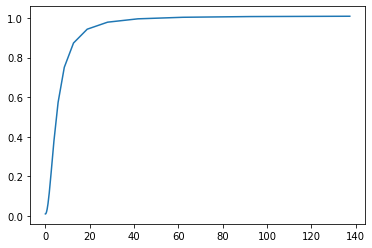

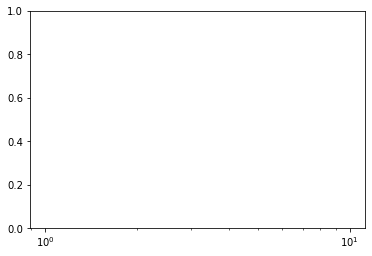

In [53]:
y1 = low_pass([1, tau_1, 1e-2], frequencies)
plt.plot(frequencies, y1)
plt.show()
plt.xscale('log')

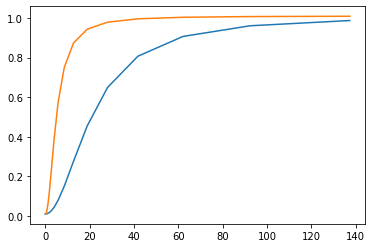

No handles with labels found to put in legend.


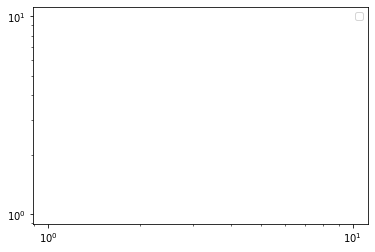

In [54]:
y2 = low_pass([1, tau_2, 1e-2], frequencies)
plt.plot(frequencies, y2, label = 'y2')
plt.plot(frequencies, y1, label = 'y1')
plt.show()
plt.legend()
plt.yscale('log')
plt.xscale('log')

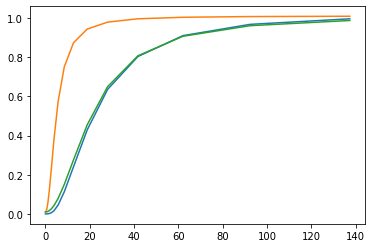

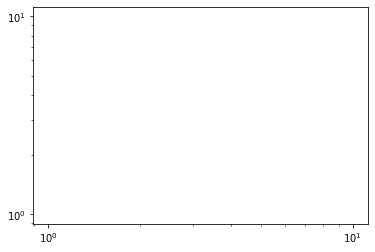

In [55]:
plt.plot(frequencies, y1*y2)
plt.plot(frequencies, y1)
plt.plot(frequencies, y2)


plt.show()
plt.yscale('log')
plt.xscale('log')

In [56]:
y3 = y1 * y2

In [57]:


y1 = low_pass([100, tau_1, 1], frequencies)
y2 = low_pass([100, tau_2, 1], frequencies)

y3 = y1 * y2

x0 = [0.1, 0.1, 0.1]
OptimizeResult  = optimize.least_squares(residuals,  x0, bounds = (-1e5,1e5),
                                      args = (frequencies, y3, low_pass))
parameters_estimated = OptimizeResult.x

In [58]:
tau_2

0.047415563404329626